In [1]:
from prophet import Prophet

In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [17]:
mat = np.empty((0, 5))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['country', 'model', 'mae', 'mase', 'rsq'])

# Belgium

## train/test split

In [18]:
belgium = pd.read_csv('univariate_df_Belgium.csv')
belgium['date'] = pd.to_datetime(belgium['date'])
belgium = belgium.drop('Unnamed: 0', axis=1)
belgium = belgium.rename(columns={'date': 'ds', 'new_deaths': 'y'})
belgium = belgium.sort_index()
train_size = int(len(belgium) * 0.7)
belgium_train, belgium_test = belgium[0:train_size], belgium[train_size:]
print(belgium_train.shape, belgium_test.shape)

(141, 2) (61, 2)


## Baseline Prophet

10:34:30 - cmdstanpy - INFO - Chain [1] start processing
10:34:30 - cmdstanpy - INFO - Chain [1] done processing


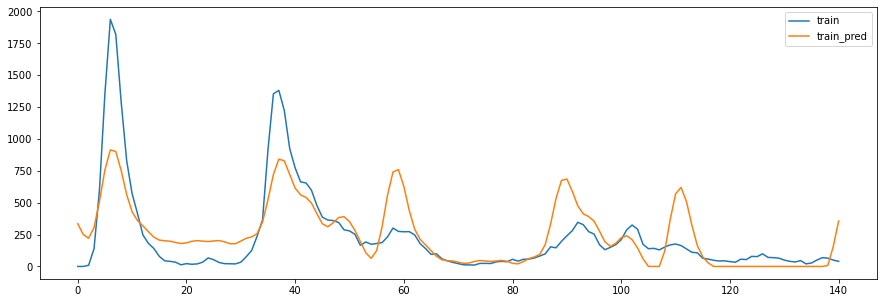

In [19]:
model = prophet.Prophet().fit(belgium_train)
train_pred=model.predict(belgium_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([belgium_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])


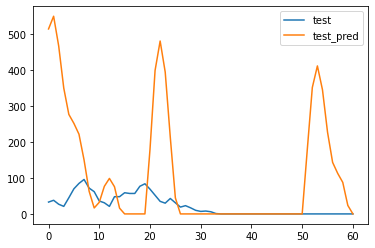

In [20]:
test_pred=model.predict(belgium_test)
belgium_test_reset = belgium_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values 
pd.concat([belgium_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [21]:
mae = mean_absolute_error(belgium_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(belgium_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(belgium_test_reset['y'], test_pred_reset['yhat'], y_train = belgium_train['y'])
new_row = {'country': 'Belgium', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [22]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(belgium_train)

        # calculate AIC
        residuals = belgium_train['y'] - model.predict(belgium_train)['yhat']
        n = len(belgium_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:34:31 - cmdstanpy - INFO - Chain [1] start processing
10:34:31 - cmdstanpy - INFO - Chain [1] done processing
10:34:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:34:31 - cmdstanpy - INFO - Chain [1] start processing


10:34:35 - cmdstanpy - INFO - Chain [1] done processing
10:34:35 - cmdstanpy - INFO - Chain [1] start processing
10:34:35 - cmdstanpy - INFO - Chain [1] done processing
10:34:35 - cmdstanpy - INFO - Chain [1] start processing
10:34:35 - cmdstanpy - INFO - Chain [1] done processing
10:34:36 - cmdstanpy - INFO - Chain [1] start processing
10:34:36 - cmdstanpy - INFO - Chain [1] done processing
10:34:36 - cmdstanpy - INFO - Chain [1] start processing
10:34:36 - cmdstanpy - INFO - Chain [1] done processing
10:34:36 - cmdstanpy - INFO - Chain [1] start processing
10:34:36 - cmdstanpy - INFO - Chain [1] done processing
10:34:37 - cmdstanpy - INFO - Chain [1] start processing
10:34:37 - cmdstanpy - INFO - Chain [1] done processing
10:34:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:34:37 - cmdstanpy - INFO - Chain [1] start processing
10:34:37 - cmdstanpy - INFO - Chain [1] done processi

,s,c,aic
23,0.1000,0.500,1528.777722
35,10.0000,0.500,1529.784517
29,1.0000,0.500,1529.972537
34,10.0000,0.100,1536.069629
22,0.1000,0.100,1536.158956
28,1.0000,0.100,1536.313554
21,0.1000,0.050,1545.204044
33,10.0000,0.050,1545.342932
27,1.0000,0.050,1545.801856
24,1.0000,0.001,1546.152257


10:34:45 - cmdstanpy - INFO - Chain [1] start processing
10:34:46 - cmdstanpy - INFO - Chain [1] done processing


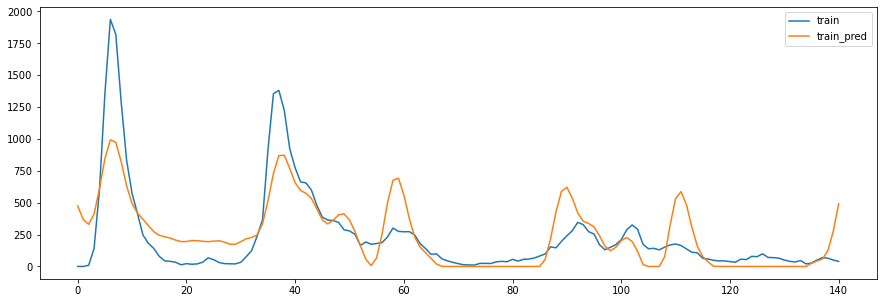

In [23]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.1).fit(belgium_train)
train_pred=model.predict(belgium_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([belgium_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

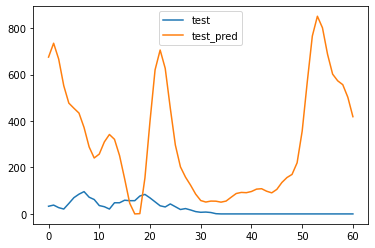

In [24]:
test_pred=model.predict(belgium_test)
belgium_test_reset = belgium_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values 
pd.concat([belgium_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [25]:
mae = mean_absolute_error(belgium_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(belgium_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(belgium_test_reset['y'], test_pred_reset['yhat'], y_train = belgium_train['y'])
new_row = {'country': 'Belgium', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Chile

## train/test split

In [26]:
chile = pd.read_csv('univariate_df_Chile.csv')
chile['date'] = pd.to_datetime(chile['date'])
chile = chile.drop('Unnamed: 0', axis=1)
chile = chile.rename(columns={'date': 'ds', 'new_deaths': 'y'})
chile = chile.sort_index()
train_size = int(len(chile) * 0.7)
chile_train, chile_test = chile[0:train_size], chile[train_size:]
print(chile_train.shape, chile_test.shape)

(141, 2) (61, 2)


## Baseline Prophet

10:34:47 - cmdstanpy - INFO - Chain [1] start processing
10:34:47 - cmdstanpy - INFO - Chain [1] done processing


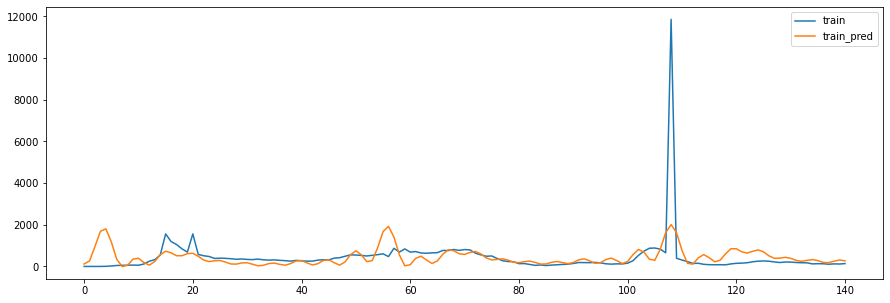

In [27]:
model = prophet.Prophet().fit(chile_train)
train_pred=model.predict(chile_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([chile_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

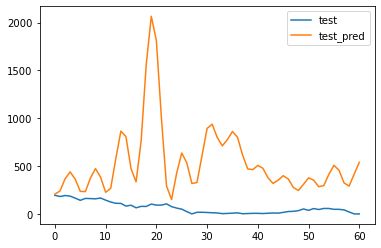

In [28]:
test_pred=model.predict(chile_test)
chile_test_reset = chile_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([chile_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [29]:
mae = mean_absolute_error(chile_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(chile_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(chile_test_reset['y'], test_pred_reset['yhat'], y_train = chile_train['y'])
new_row = {'country': 'Chile', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [30]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(chile_train)

        # calculate AIC
        residuals = chile_train['y'] - model.predict(chile_train)['yhat']
        n = len(chile_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:34:48 - cmdstanpy - INFO - Chain [1] start processing
10:34:48 - cmdstanpy - INFO - Chain [1] done processing


10:34:48 - cmdstanpy - INFO - Chain [1] start processing
10:34:48 - cmdstanpy - INFO - Chain [1] done processing
10:34:49 - cmdstanpy - INFO - Chain [1] start processing
10:34:49 - cmdstanpy - INFO - Chain [1] done processing
10:34:49 - cmdstanpy - INFO - Chain [1] start processing
10:34:49 - cmdstanpy - INFO - Chain [1] done processing
10:34:49 - cmdstanpy - INFO - Chain [1] start processing
10:34:49 - cmdstanpy - INFO - Chain [1] done processing
10:34:49 - cmdstanpy - INFO - Chain [1] start processing
10:34:49 - cmdstanpy - INFO - Chain [1] done processing
10:34:49 - cmdstanpy - INFO - Chain [1] start processing
10:34:49 - cmdstanpy - INFO - Chain [1] done processing
10:34:50 - cmdstanpy - INFO - Chain [1] start processing
10:34:50 - cmdstanpy - INFO - Chain [1] done processing
10:34:50 - cmdstanpy - INFO - Chain [1] start processing
10:34:50 - cmdstanpy - INFO - Chain [1] done processing
10:34:50 - cmdstanpy - INFO - Chain [1] start processing
10:34:50 - cmdstanpy - INFO - Chain [1]

,s,c,aic
23,0.1000,0.500,1931.357003
29,1.0000,0.500,1931.855337
35,10.0000,0.500,1932.010661
17,0.0100,0.500,1937.055534
34,10.0000,0.100,1940.679705
28,1.0000,0.100,1941.048223
22,0.1000,0.100,1941.055983
33,10.0000,0.050,1941.566462
21,0.1000,0.050,1941.572361
27,1.0000,0.050,1941.587260


10:34:55 - cmdstanpy - INFO - Chain [1] start processing


10:34:55 - cmdstanpy - INFO - Chain [1] done processing


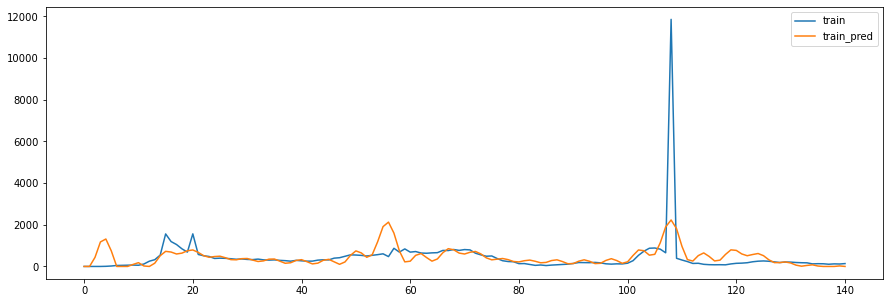

In [31]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.1).fit(chile_train)
train_pred=model.predict(chile_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([chile_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

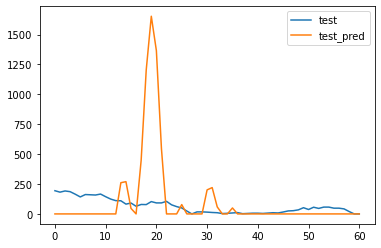

In [32]:
test_pred=model.predict(chile_test)
chile_test_reset = chile_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([chile_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [33]:
mae = mean_absolute_error(chile_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(chile_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(chile_test_reset['y'], test_pred_reset['yhat'], y_train = chile_train['y'])
new_row = {'country': 'Chile', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Ireland

## train/test split

In [34]:
ireland = pd.read_csv('univariate_df_Ireland.csv')
ireland['date'] = pd.to_datetime(ireland['date'])
ireland = ireland.drop('Unnamed: 0', axis=1)
ireland = ireland.rename(columns={'date': 'ds', 'new_deaths': 'y'})
ireland = ireland.sort_index()
train_size = int(len(ireland) * 0.7)
ireland_train, ireland_test = ireland[0:train_size], ireland[train_size:]
print(ireland_train.shape, ireland_test.shape)

(141, 2) (61, 2)


## Baseline Prophet

10:34:56 - cmdstanpy - INFO - Chain [1] start processing
10:34:56 - cmdstanpy - INFO - Chain [1] done processing


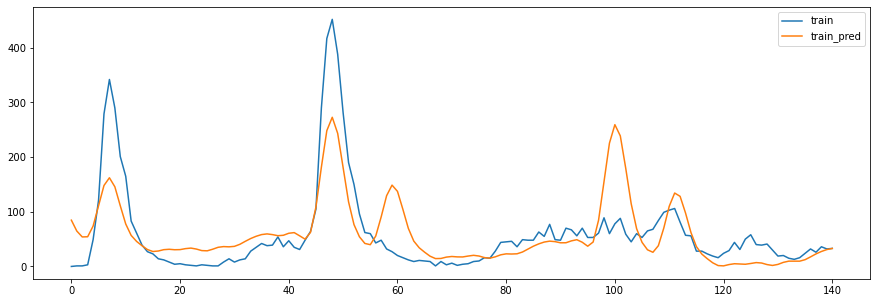

In [35]:
model = prophet.Prophet().fit(ireland_train)
train_pred=model.predict(ireland_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([ireland_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

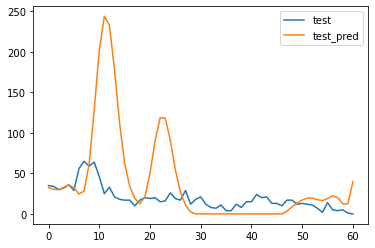

In [36]:
test_pred=model.predict(ireland_test)
ireland_test_reset = ireland_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([ireland_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [37]:
mae = mean_absolute_error(ireland_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(ireland_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(ireland_test_reset['y'], test_pred_reset['yhat'], y_train = ireland_train['y'])
new_row = {'country': 'Ireland', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [38]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(ireland_train)

        # calculate AIC
        residuals = ireland_train['y'] - model.predict(ireland_train)['yhat']
        n = len(ireland_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:34:57 - cmdstanpy - INFO - Chain [1] start processing
10:34:57 - cmdstanpy - INFO - Chain [1] done processing
10:34:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:34:57 - cmdstanpy - INFO - Chain [1] start processing


10:34:57 - cmdstanpy - INFO - Chain [1] done processing
10:34:58 - cmdstanpy - INFO - Chain [1] start processing
10:34:58 - cmdstanpy - INFO - Chain [1] done processing
10:34:58 - cmdstanpy - INFO - Chain [1] start processing
10:34:58 - cmdstanpy - INFO - Chain [1] done processing
10:34:58 - cmdstanpy - INFO - Chain [1] start processing
10:34:58 - cmdstanpy - INFO - Chain [1] done processing
10:34:58 - cmdstanpy - INFO - Chain [1] start processing
10:34:58 - cmdstanpy - INFO - Chain [1] done processing
10:34:59 - cmdstanpy - INFO - Chain [1] start processing
10:34:59 - cmdstanpy - INFO - Chain [1] done processing
10:34:59 - cmdstanpy - INFO - Chain [1] start processing
10:34:59 - cmdstanpy - INFO - Chain [1] done processing
10:34:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:34:59 - cmdstanpy - INFO - Chain [1] start processing
10:34:59 - cmdstanpy - INFO - Chain [1] done processi

,s,c,aic
29,1.0000,0.500,1135.744455
23,0.1000,0.500,1135.774160
35,10.0000,0.500,1136.121715
22,0.1000,0.100,1144.990388
34,10.0000,0.100,1145.246300
28,1.0000,0.100,1145.342778
30,10.0000,0.001,1145.511024
24,1.0000,0.001,1145.511028
33,10.0000,0.050,1145.519134
27,1.0000,0.050,1145.537186


10:35:13 - cmdstanpy - INFO - Chain [1] start processing
10:35:14 - cmdstanpy - INFO - Chain [1] done processing


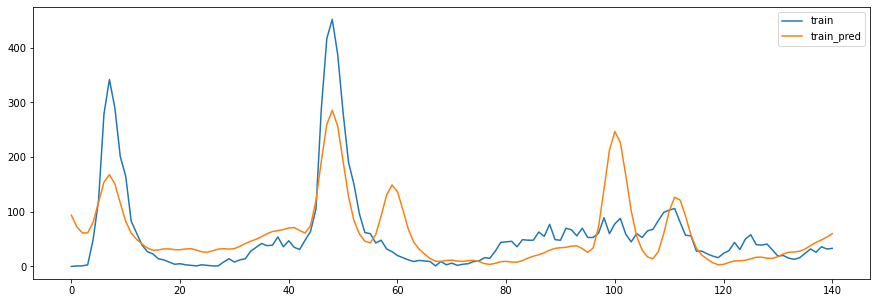

In [39]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1).fit(ireland_train)
train_pred=model.predict(ireland_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([ireland_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

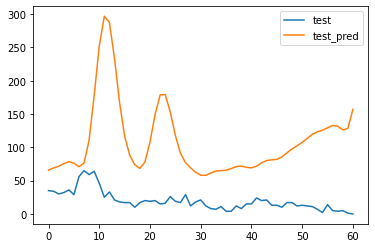

In [40]:
test_pred=model.predict(ireland_test)
ireland_test_reset = ireland_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([ireland_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [41]:
mae = mean_absolute_error(ireland_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(ireland_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(ireland_test_reset['y'], test_pred_reset['yhat'], y_train = ireland_train['y'])
new_row = {'country': 'Ireland', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Israel

## train/test split

In [42]:
israel = pd.read_csv('univariate_df_Israel.csv')
israel['date'] = pd.to_datetime(israel['date'])
israel = israel.drop('Unnamed: 0', axis=1)
israel = israel.rename(columns={'date': 'ds', 'new_deaths': 'y'})
israel = israel.sort_index()
train_size = int(len(israel) * 0.7)
israel_train, israel_test = israel[0:train_size], israel[train_size:]
print(israel_train.shape, israel_test.shape)

(141, 2) (61, 2)


## Baseline Prophet

10:35:15 - cmdstanpy - INFO - Chain [1] start processing
10:35:15 - cmdstanpy - INFO - Chain [1] done processing


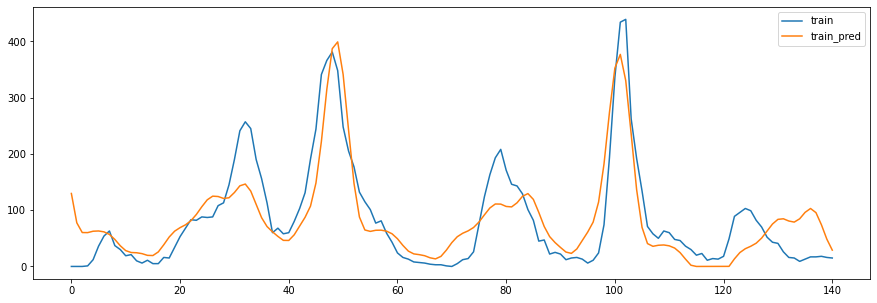

In [43]:
model = prophet.Prophet().fit(israel_train)
train_pred=model.predict(israel_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([israel_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

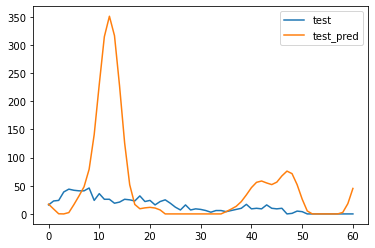

In [44]:
test_pred=model.predict(israel_test)
israel_test_reset = israel_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([israel_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [45]:
mae = mean_absolute_error(israel_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(israel_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(israel_test_reset['y'], test_pred_reset['yhat'], y_train = israel_train['y'])
new_row = {'country': 'Israel', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [46]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(israel_train)

        # calculate AIC
        residuals = israel_train['y'] - model.predict(israel_train)['yhat']
        n = len(israel_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:35:16 - cmdstanpy - INFO - Chain [1] start processing
10:35:16 - cmdstanpy - INFO - Chain [1] done processing
10:35:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:16 - cmdstanpy - INFO - Chain [1] start processing
10:35:16 - cmdstanpy - INFO - Chain [1] done processing
10:35:17 - cmdstanpy - INFO - Chain [1] start processing
10:35:17 - cmdstanpy - INFO - Chain [1] done processing
10:35:17 - cmdstanpy - INFO - Chain [1] start processing
10:35:17 - cmdstanpy - INFO - Chain [1] done processing
10:35:17 - cmdstanpy - INFO - Chain [1] start processing
10:35:17 - cmdstanpy - INFO - Chain [1] done processing
10:35:17 - cmdstanpy - INFO - Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing
10:35:18 - cmdstanpy - INFO - Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing
10:35:18 - cmdstanpy - INFO - Chain [1] start process

,s,c,aic
35,10.0000,0.500,1044.421354
29,1.0000,0.500,1044.606936
23,0.1000,0.500,1044.795164
34,10.0000,0.100,1088.930183
22,0.1000,0.100,1088.948624
28,1.0000,0.100,1090.354534
21,0.1000,0.050,1109.253647
33,10.0000,0.050,1109.567220
27,1.0000,0.050,1109.765288
24,1.0000,0.001,1121.003613


10:35:40 - cmdstanpy - INFO - Chain [1] start processing


10:35:40 - cmdstanpy - INFO - Chain [1] done processing


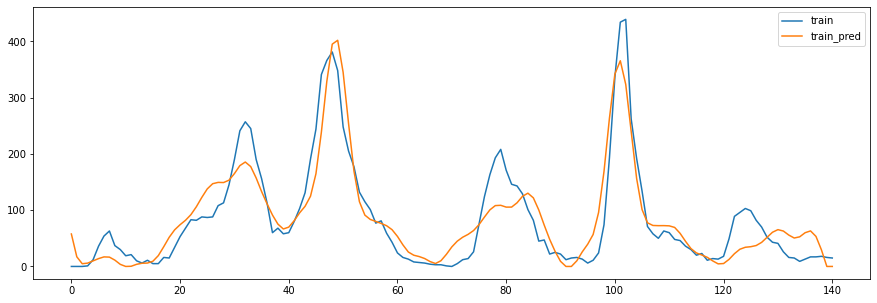

In [47]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10).fit(israel_train)
train_pred=model.predict(israel_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([israel_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

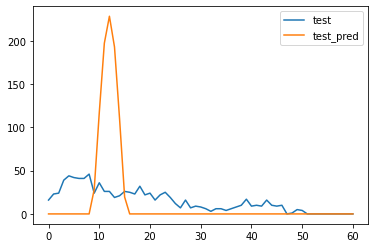

In [48]:
test_pred=model.predict(israel_test)
israel_test_reset = israel_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([israel_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [49]:
mae = mean_absolute_error(israel_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(israel_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(israel_test_reset['y'], test_pred_reset['yhat'], y_train = israel_train['y'])
new_row = {'country': 'Israel', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Italy

## train/test split

In [50]:
italy = pd.read_csv('univariate_df_Italy.csv')
italy['date'] = pd.to_datetime(italy['date'])
italy = italy.drop('Unnamed: 0', axis=1)
italy = italy.rename(columns={'date': 'ds', 'new_deaths': 'y'})
italy = italy.sort_index()
train_size = int(len(italy) * 0.7)
italy_train, italy_test = italy[0:train_size], italy[train_size:]
print(italy_train.shape, italy_test.shape)

(141, 2) (61, 2)


## Baseline Prophet

10:35:42 - cmdstanpy - INFO - Chain [1] start processing
10:35:42 - cmdstanpy - INFO - Chain [1] done processing


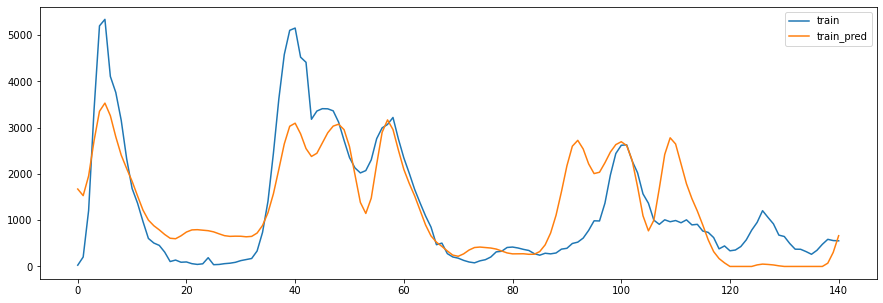

In [51]:
model = prophet.Prophet().fit(italy_train)
train_pred=model.predict(italy_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([italy_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

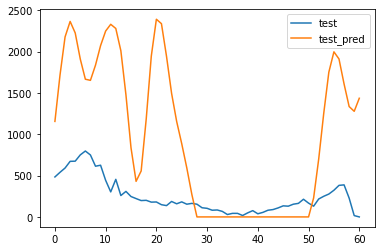

In [52]:
test_pred=model.predict(italy_test)
italy_test_reset = italy_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([italy_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [53]:
mae = mean_absolute_error(italy_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(italy_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(italy_test_reset['y'], test_pred_reset['yhat'], y_train = italy_train['y'])
new_row = {'country': 'Italy', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [54]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(italy_train)

        # calculate AIC
        residuals = italy_train['y'] - model.predict(italy_train)['yhat']
        n = len(italy_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:35:43 - cmdstanpy - INFO - Chain [1] start processing
10:35:43 - cmdstanpy - INFO - Chain [1] done processing
10:35:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:43 - cmdstanpy - INFO - Chain [1] start processing


10:35:44 - cmdstanpy - INFO - Chain [1] done processing
10:35:44 - cmdstanpy - INFO - Chain [1] start processing
10:35:44 - cmdstanpy - INFO - Chain [1] done processing
10:35:44 - cmdstanpy - INFO - Chain [1] start processing
10:35:44 - cmdstanpy - INFO - Chain [1] done processing
10:35:45 - cmdstanpy - INFO - Chain [1] start processing
10:35:45 - cmdstanpy - INFO - Chain [1] done processing
10:35:45 - cmdstanpy - INFO - Chain [1] start processing
10:35:45 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:47 - cmdstanpy - INFO - Chain [1] done processi

,s,c,aic
29,1.0000,0.500,1827.516586
23,0.1000,0.500,1827.709900
35,10.0000,0.500,1828.370463
17,0.0100,0.500,1877.246887
28,1.0000,0.100,1881.067759
34,10.0000,0.100,1881.243244
22,0.1000,0.100,1883.051271
33,10.0000,0.050,1903.384090
27,1.0000,0.050,1903.823785
24,1.0000,0.001,1903.939896


10:35:57 - cmdstanpy - INFO - Chain [1] start processing


10:35:57 - cmdstanpy - INFO - Chain [1] done processing


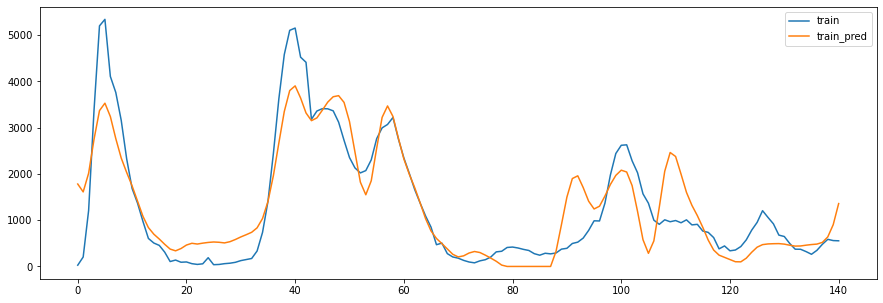

In [55]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1).fit(italy_train)
train_pred=model.predict(italy_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([italy_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

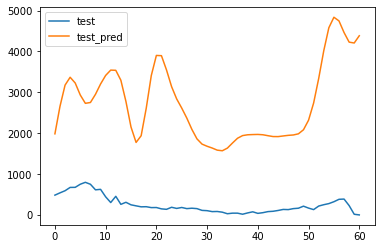

In [56]:
test_pred=model.predict(italy_test)
italy_test_reset = italy_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([italy_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [57]:
mae = mean_absolute_error(italy_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(italy_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(italy_test_reset['y'], test_pred_reset['yhat'], y_train = italy_train['y'])
new_row = {'country': 'Italy', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# United States

## train/test split

In [58]:
us = pd.read_csv('univariate_df_United_States.csv')
us['date'] = pd.to_datetime(us['date'])
us = us.drop('Unnamed: 0', axis=1)
us = us.rename(columns={'date': 'ds', 'new_deaths': 'y'})
us = us.sort_index()
train_size = int(len(us) * 0.7)
us_train, us_test = us[0:train_size], us[train_size:]
print(us_train.shape, us_test.shape)

(141, 3) (61, 3)


## Baseline Prophet

10:35:58 - cmdstanpy - INFO - Chain [1] start processing
10:35:58 - cmdstanpy - INFO - Chain [1] done processing


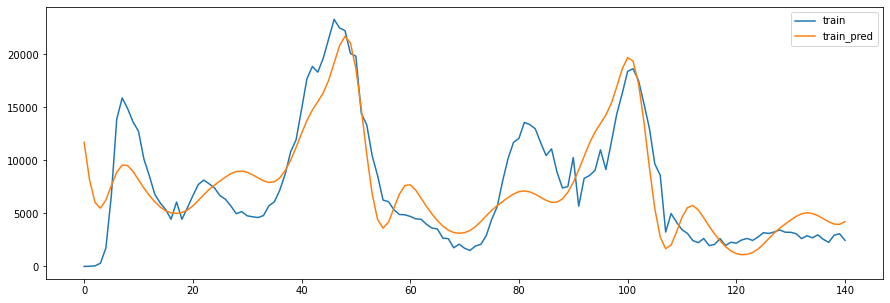

In [59]:
model = prophet.Prophet().fit(us_train)
train_pred=model.predict(us_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([us_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

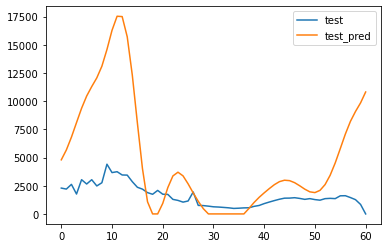

In [60]:
test_pred=model.predict(us_test)
us_test_reset = us_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([us_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [61]:
mae = mean_absolute_error(us_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(us_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(us_test_reset['y'], test_pred_reset['yhat'], y_train = us_train['y'])
new_row = {'country': 'US', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [62]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(us_train)

        # calculate AIC
        residuals = us_train['y'] - model.predict(us_train)['yhat']
        n = len(us_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:01 - cmdstanpy - INFO - Chain [1] start processing
10:36:01 - cmdstanpy - INFO - Chain [1] done processing
10:36:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:01 - cmdstanpy - INFO - Chain [1] start processing
10:36:01 - cmdstanpy - INFO - Chain [1] done processing
10:36:02 - cmdstanpy - INFO - Chain [1] start processing
10:36:02 - cmdstanpy - INFO - Chain [1] done processing
10:36:02 - cmdstanpy - INFO - Chain [1] start processing
10:36:02 - cmdstanpy - INFO - Chain [1] done processing
10:36:02 -

,s,c,aic
23,0.1000,0.500,2111.163122
29,1.0000,0.500,2128.447020
35,10.0000,0.500,2171.726775
22,0.1000,0.100,2268.608009
28,1.0000,0.100,2268.741317
34,10.0000,0.100,2268.839037
33,10.0000,0.050,2274.399064
27,1.0000,0.050,2274.533418
21,0.1000,0.050,2274.738427
25,1.0000,0.005,2275.181847


10:36:17 - cmdstanpy - INFO - Chain [1] start processing
10:36:17 - cmdstanpy - INFO - Chain [1] done processing


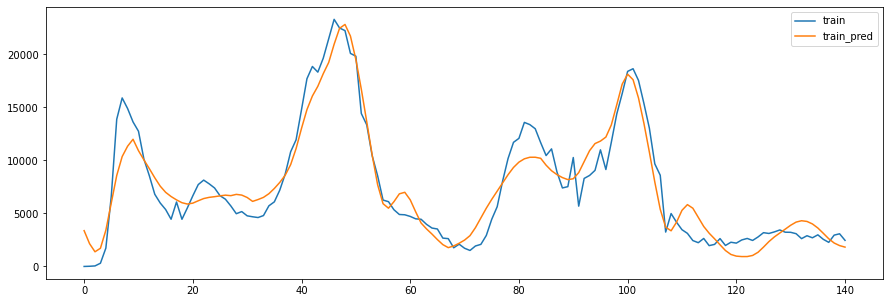

In [63]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.1).fit(us_train)
train_pred=model.predict(us_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([us_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

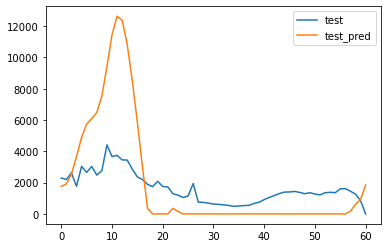

In [64]:
test_pred=model.predict(us_test)
us_test_reset = us_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([us_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [65]:
mae = mean_absolute_error(us_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(us_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(us_test_reset['y'], test_pred_reset['yhat'], y_train = us_train['y'])
new_row = {'country': 'US', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Czechia

## train/test split

In [66]:
czechia = pd.read_csv('univariate_df_Czechia.csv')
czechia['date'] = pd.to_datetime(czechia['date'])
czechia = czechia.drop('Unnamed: 0', axis=1)
czechia = czechia.rename(columns={'date': 'ds', 'new_deaths': 'y'})
czechia = czechia.sort_index()
train_size = int(len(czechia) * 0.7)
czechia_train, czechia_test = czechia[0:train_size], czechia[train_size:]
print(czechia_train.shape, czechia_test.shape)

(141, 3) (61, 3)


## Baseline Prophet

10:36:19 - cmdstanpy - INFO - Chain [1] start processing
10:36:19 - cmdstanpy - INFO - Chain [1] done processing


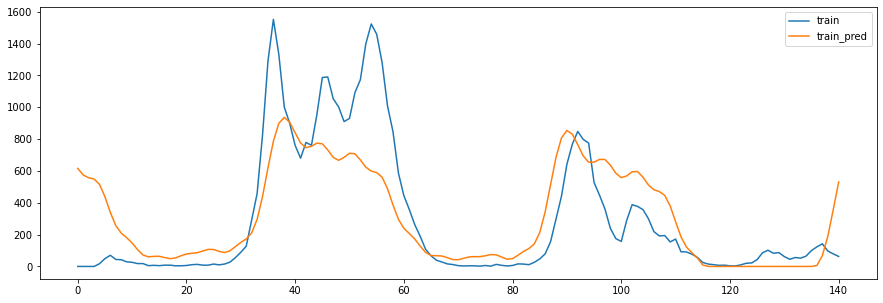

In [67]:
model = prophet.Prophet().fit(czechia_train)
train_pred=model.predict(czechia_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([czechia_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

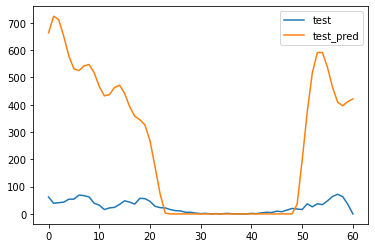

In [68]:
test_pred=model.predict(czechia_test)
czechia_test_reset = czechia_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([czechia_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [69]:
mae = mean_absolute_error(czechia_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(czechia_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(czechia_test_reset['y'], test_pred_reset['yhat'], y_train = czechia_train['y'])
new_row = {'country': 'Czechia', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [70]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(czechia_train)

        # calculate AIC
        residuals = czechia_train['y'] - model.predict(czechia_train)['yhat']
        n = len(czechia_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:36:20 - cmdstanpy - INFO - Chain [1] start processing


10:36:20 - cmdstanpy - INFO - Chain [1] done processing
10:36:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:20 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:22 - cmdstanpy - INFO - Chain [1] start processing
10:36:22 - cmdstanpy - INFO - Chain [1] done processing
10:36:22 - cmdstanpy - INFO - Chain [1] start processing
10:36:22 - cmdstanpy - INFO - Chain [1] done processing
10:36:22 - cmdstanpy - INFO - Chain [1] start processing
10:36:22 - cmdstanpy - INFO - Chain [1] done processi

,s,c,aic
29,1.0000,0.500,1434.878908
23,0.1000,0.500,1435.617509
35,10.0000,0.500,1436.780106
17,0.0100,0.500,1452.226513
22,0.1000,0.100,1491.608287
34,10.0000,0.100,1492.329262
28,1.0000,0.100,1492.347199
11,0.0010,0.500,1500.231086
5,0.0001,0.500,1548.596552
33,10.0000,0.050,1594.186309


10:36:33 - cmdstanpy - INFO - Chain [1] start processing


10:36:33 - cmdstanpy - INFO - Chain [1] done processing


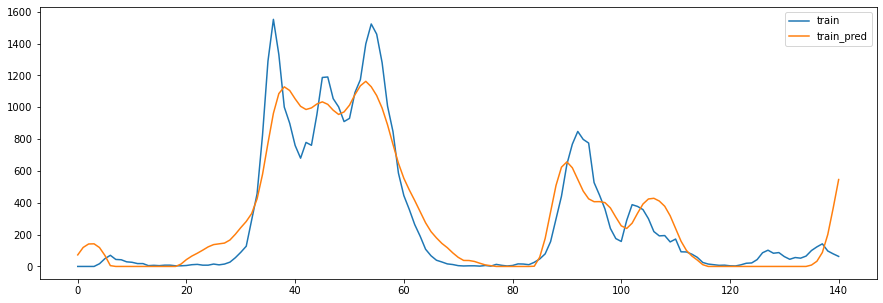

In [71]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1).fit(czechia_train)
train_pred=model.predict(czechia_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([czechia_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

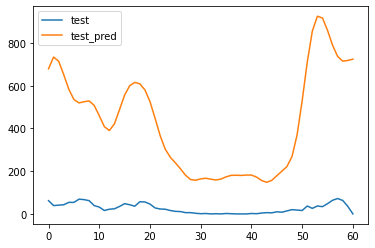

In [72]:
test_pred=model.predict(czechia_test)
czechia_test_reset = czechia_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([czechia_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [73]:
mae = mean_absolute_error(czechia_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(czechia_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(czechia_test_reset['y'], test_pred_reset['yhat'], y_train = czechia_train['y'])
new_row = {'country': 'Czechia', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Estonia

## train/test split

In [74]:
estonia = pd.read_csv('univariate_df_Estonia.csv')
estonia['date'] = pd.to_datetime(estonia['date'])
estonia = estonia.drop('Unnamed: 0', axis=1)
estonia = estonia.rename(columns={'date': 'ds', 'new_deaths': 'y'})
estonia = estonia.sort_index()
train_size = int(len(estonia) * 0.7)
estonia_train, estonia_test = estonia[0:train_size], estonia[train_size:]
print(estonia_train.shape, estonia_test.shape)

(141, 3) (61, 3)


## Baseline Prophet

10:36:34 - cmdstanpy - INFO - Chain [1] start processing
10:36:34 - cmdstanpy - INFO - Chain [1] done processing


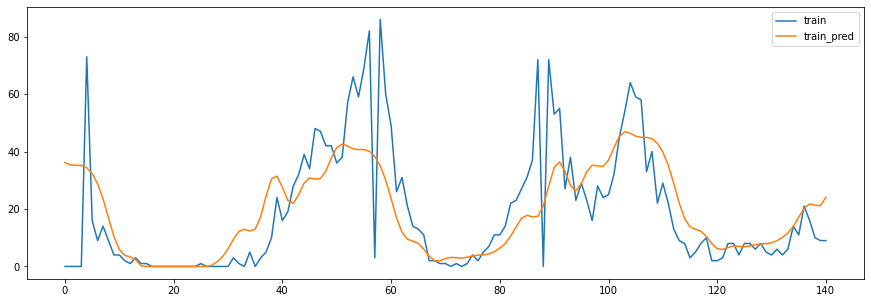

In [75]:
model = prophet.Prophet().fit(estonia_train)
train_pred=model.predict(estonia_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([estonia_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

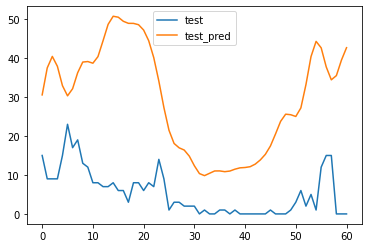

In [76]:
test_pred=model.predict(estonia_test)
estonia_test_reset = estonia_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([estonia_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [77]:
mae = mean_absolute_error(estonia_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(estonia_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(estonia_test_reset['y'], test_pred_reset['yhat'], y_train = estonia_train['y'])
new_row = {'country': 'Estonia', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [78]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(estonia_train)

        # calculate AIC
        residuals = estonia_train['y'] - model.predict(estonia_train)['yhat']
        n = len(estonia_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing
10:36:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:35 - cmdstanpy - INFO - Chain [1] start processing


10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:37 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing
10:36:37 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing
10:36:37 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] start processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] start processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processi

,s,c,aic
23,0.1000,0.500,740.574484
35,10.0000,0.500,740.775133
29,1.0000,0.500,740.840950
28,1.0000,0.100,748.448608
34,10.0000,0.100,749.548210
22,0.1000,0.100,749.993541
27,1.0000,0.050,774.885386
21,0.1000,0.050,774.994827
33,10.0000,0.050,775.029459
31,10.0000,0.005,777.276656


10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing


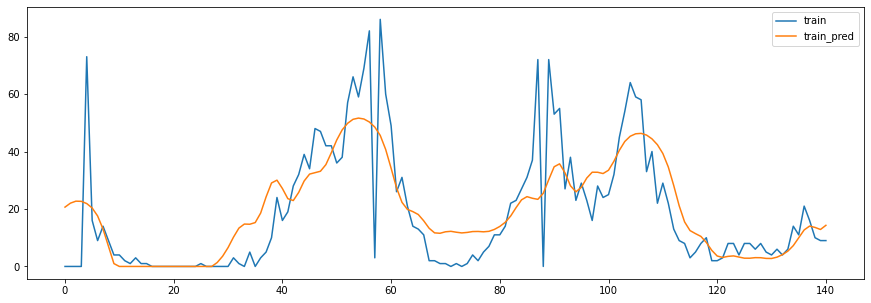

In [79]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.1).fit(estonia_train)
train_pred=model.predict(estonia_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([estonia_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

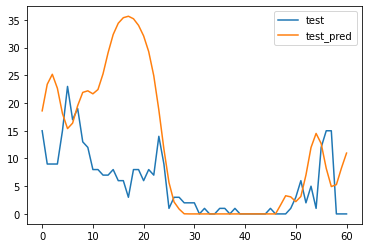

In [80]:
test_pred=model.predict(estonia_test)
estonia_test_reset = estonia_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([estonia_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [81]:
mae = mean_absolute_error(estonia_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(estonia_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(estonia_test_reset['y'], test_pred_reset['yhat'], y_train = estonia_train['y'])
new_row = {'country': 'Estonia', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# France

## train/test split

In [82]:
france = pd.read_csv('univariate_df_France.csv')
france['date'] = pd.to_datetime(france['date'])
france = france.drop('Unnamed: 0', axis=1)
france = france.rename(columns={'date': 'ds', 'new_deaths': 'y'})
france = france.sort_index()
train_size = int(len(france) * 0.7)
france_train, france_test = france[0:train_size], france[train_size:]
print(france_train.shape, france_test.shape)

(141, 3) (61, 3)


## Baseline Prophet

10:36:52 - cmdstanpy - INFO - Chain [1] start processing
10:36:52 - cmdstanpy - INFO - Chain [1] done processing


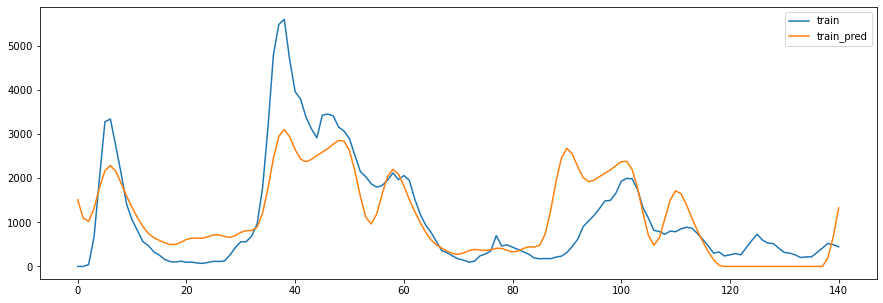

In [83]:
model = prophet.Prophet().fit(france_train)
train_pred=model.predict(france_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([france_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

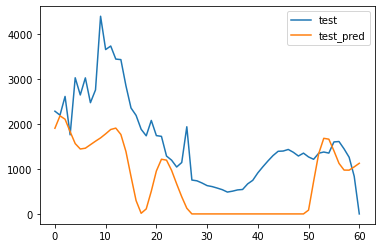

In [84]:
test_pred=model.predict(france_test)
france_test_reset = france_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([us_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [85]:
mae = mean_absolute_error(france_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(france_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(france_test_reset['y'], test_pred_reset['yhat'], y_train = france_train['y'])
new_row = {'country': 'France', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [86]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(france_train)

        # calculate AIC
        residuals = france_train['y'] - model.predict(france_train)['yhat']
        n = len(france_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:36:53 - cmdstanpy - INFO - Chain [1] start processing


10:36:53 - cmdstanpy - INFO - Chain [1] done processing
10:36:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] done processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] done processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] done processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] done processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:55 - cmdstanpy - INFO - Chain [1] done processing
10:36:55 - cmdstanpy - INFO - Chain [1] start processing
10:36:55 - cmdstanpy - INFO - Chain [1] done processing
10:36:55 - cmdstanpy - INFO - Chain [1] start processing
10:36:55 - cmdstanpy - INFO - Chain [1] done processi

,s,c,aic
23,0.1000,0.500,1760.421027
35,10.0000,0.500,1764.580384
29,1.0000,0.500,1764.603037
17,0.0100,0.500,1772.366243
34,10.0000,0.100,1820.538640
22,0.1000,0.100,1823.658681
28,1.0000,0.100,1825.928513
11,0.0010,0.500,1840.147446
5,0.0001,0.500,1870.294111
33,10.0000,0.050,1884.464000


10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:07 - cmdstanpy - INFO - Chain [1] done processing


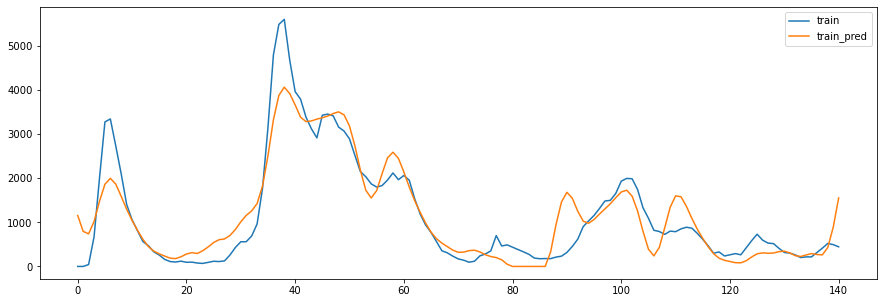

In [87]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.1).fit(france_train)
train_pred=model.predict(france_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([france_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

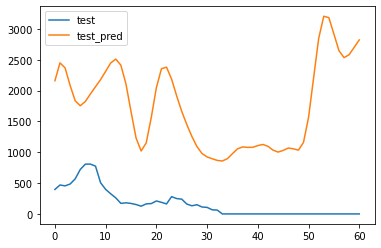

In [88]:
test_pred=model.predict(france_test)
france_test_reset = france_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([france_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [89]:
mae = mean_absolute_error(france_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(france_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(france_test_reset['y'], test_pred_reset['yhat'], y_train = france_train['y'])
new_row = {'country': 'France', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Malaysia

## train/test split

In [90]:
malaysia = pd.read_csv('univariate_df_Malaysia.csv')
malaysia['date'] = pd.to_datetime(malaysia['date'])
malaysia = malaysia.drop('Unnamed: 0', axis=1)
malaysia = malaysia.rename(columns={'date': 'ds', 'new_deaths': 'y'})
malaysia = malaysia.sort_index()
train_size = int(len(malaysia) * 0.7)
malaysia_train, malaysia_test = malaysia[0:train_size], malaysia[train_size:]
print(malaysia_train.shape, malaysia_test.shape)

(141, 3) (61, 3)


## Baseline Prophet

10:37:08 - cmdstanpy - INFO - Chain [1] start processing
10:37:08 - cmdstanpy - INFO - Chain [1] done processing


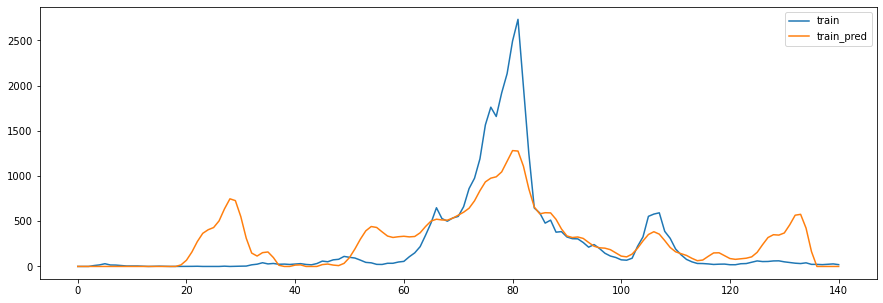

In [91]:
model = prophet.Prophet().fit(malaysia_train)
train_pred=model.predict(malaysia_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values 
pd.concat([malaysia_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

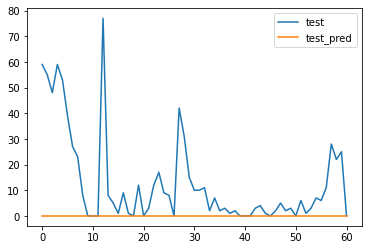

In [92]:
test_pred=model.predict(malaysia_test)
malaysia_test_reset = malaysia_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([malaysia_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [93]:
mae = mean_absolute_error(malaysia_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(malaysia_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(malaysia_test_reset['y'], test_pred_reset['yhat'], y_train = malaysia_train['y'])
new_row = {'country': 'Malaysia', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Tuned Prophet

In [94]:
results = []
s_scale = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
c_scale = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for s in s_scale:
    for c in c_scale:
        model = prophet.Prophet(changepoint_prior_scale=c, seasonality_prior_scale=s).fit(malaysia_train)

        # calculate AIC
        residuals = malaysia_train['y'] - model.predict(malaysia_train)['yhat']
        n = len(malaysia_train)
        k = len(model.params)
        aic = n * np.log(np.mean(residuals ** 2)) + 2 * k
        
        results.append([s, c, aic])
pd.DataFrame(results, columns=['s', 'c', 'aic']).sort_values('aic')

10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] done processing
10:37:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:09 - cmdstanpy - INFO - Chain [1] start processing


10:37:10 - cmdstanpy - INFO - Chain [1] done processing
10:37:10 - cmdstanpy - INFO - Chain [1] start processing
10:37:10 - cmdstanpy - INFO - Chain [1] done processing
10:37:10 - cmdstanpy - INFO - Chain [1] start processing
10:37:10 - cmdstanpy - INFO - Chain [1] done processing
10:37:10 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] done processing
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] done processing
10:37:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] done processi

,s,c,aic
23,0.1000,0.500,1357.673277
35,10.0000,0.500,1380.002434
17,0.0100,0.500,1380.054633
29,1.0000,0.500,1389.108073
11,0.0010,0.500,1449.499169
5,0.0001,0.500,1571.706293
34,10.0000,0.100,1592.594479
22,0.1000,0.100,1602.604263
28,1.0000,0.100,1602.873286
33,10.0000,0.050,1639.878019


10:37:21 - cmdstanpy - INFO - Chain [1] start processing


10:37:21 - cmdstanpy - INFO - Chain [1] done processing


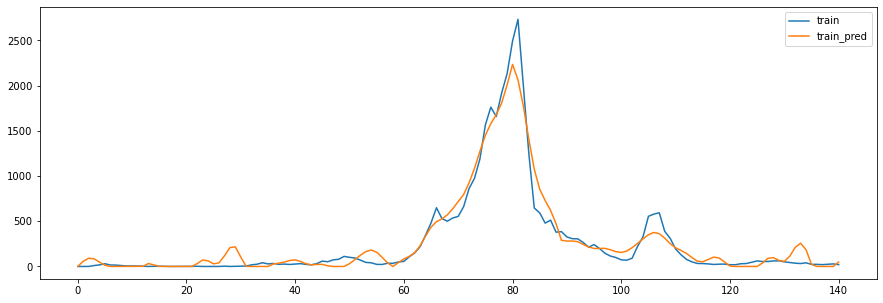

In [95]:
model = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.1).fit(malaysia_train)
train_pred=model.predict(malaysia_train)
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([malaysia_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

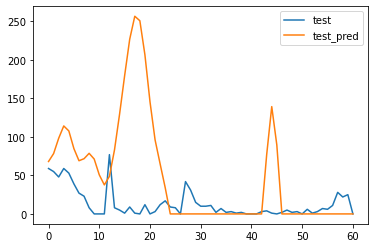

In [96]:
test_pred=model.predict(malaysia_test)
malaysia_test_reset = malaysia_test.reset_index(drop=True)
test_pred_reset = test_pred.reset_index(drop=True)
test_pred_reset['yhat'] = np.maximum(test_pred_reset['yhat'], 0) # clamp negtaive values
pd.concat([malaysia_test_reset['y'], test_pred_reset['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [97]:
mae = mean_absolute_error(malaysia_test_reset['y'], test_pred_reset['yhat'])
r2 = r2_score(malaysia_test_reset['y'], test_pred_reset['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(malaysia_test_reset['y'], test_pred_reset['yhat'], y_train = malaysia_train['y'])
new_row = {'country': 'Malaysia', 'model': 'Tuned Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Multivariate Prophet

In [98]:
multivar = pd.read_csv('multivar.csv')
multivar['date'] = pd.to_datetime(multivar['date'])
multivar = multivar.drop(columns=['iso_code'])
multivar = multivar.drop('Unnamed: 0', axis=1)
multivar = multivar.rename(columns={'date': 'ds', 'new_deaths': 'y'})
categorical_cols = ['continent', 'tests_units', 'season', 'location']
multivar = pd.get_dummies(multivar, columns=categorical_cols)
multivar = multivar.set_index('ds')

In [99]:
multivar

,total_cases,new_cases,y,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Belgium,location_Chile,location_Czechia,location_Estonia,location_France,location_Ireland,location_Israel,location_Italy,location_Malaysia,location_United States
ds,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-08,316.0,315.0,0.0,27.111,27.025,0.000,0.000,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-15,1362.0,1046.0,9.0,116.850,89.740,4.547,22.564,NaN,18.960,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-22,4473.0,3111.0,140.0,383.753,266.903,27.969,142.503,NaN,128.604,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-29,12031.0,7558.0,602.0,1032.179,648.426,82.447,389.158,NaN,300.191,NaN,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10,103436829.0,NaN,1614.0,305763.910,NaN,7.168,58.512,NaN,70.395,NaN,...,0,0,0,0,0,0,0,0,0,1
2023-12-17,103436829.0,NaN,1450.0,305763.910,NaN,7.325,62.390,NaN,75.678,NaN,...,0,0,0,0,0,0,0,0,0,1
2023-12-24,103436829.0,NaN,1263.0,305763.910,NaN,8.546,68.988,NaN,89.101,NaN,...,0,0,0,0,0,0,0,0,0,1


In [100]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['y']].join(lag1df)
    return df.fillna(0) 
multivar=process(multivar)

In [101]:
multivar = multivar.sort_index()
train_size = int(len(multivar) * 0.7)
multivar_train, multivar_test = multivar[0:train_size], multivar[train_size:]
print(multivar_train.shape, multivar_test.shape)

(14146, 68) (6063, 68)


In [102]:
model_multivariate = Prophet()
for col in multivar_train.columns:
    if col not in ['ds', 'y']:
        model_multivariate.add_regressor(col)


model_multivariate.fit(multivar_train.reset_index())

10:37:29 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
train_pred=model_multivariate.predict(multivar_train.reset_index()).set_index('ds')

In [104]:
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,...,lag1_year,lag1_year_lower,lag1_year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-03-01,468.545557,-3400.643383,3561.790860,468.545557,468.545557,-465.090435,-465.090435,-465.090435,-631.815827,-631.815827,...,27820.074986,27820.074986,27820.074986,166.725392,166.725392,166.725392,0.0,0.0,0.0,3.455122
2020-03-01,468.545557,-3517.003952,3676.416015,468.545557,468.545557,-457.649109,-457.649109,-457.649109,-624.374501,-624.374501,...,-60.697626,-60.697626,-60.697626,166.725392,166.725392,166.725392,0.0,0.0,0.0,10.896448
2020-03-01,468.545557,-3618.380795,3387.163282,468.545557,468.545557,-411.334444,-411.334444,-411.334444,-578.059836,-578.059836,...,-60.697626,-60.697626,-60.697626,166.725392,166.725392,166.725392,0.0,0.0,0.0,57.211113
2020-03-01,468.545557,-3646.649355,3297.137951,468.545557,468.545557,-465.090435,-465.090435,-465.090435,-631.815827,-631.815827,...,27820.074986,27820.074986,27820.074986,166.725392,166.725392,166.725392,0.0,0.0,0.0,3.455122
2020-03-01,468.545557,-3006.589680,3894.139941,468.545557,468.545557,-34.122065,-34.122065,-34.122065,-200.847457,-200.847457,...,-60.697626,-60.697626,-60.697626,166.725392,166.725392,166.725392,0.0,0.0,0.0,434.423492


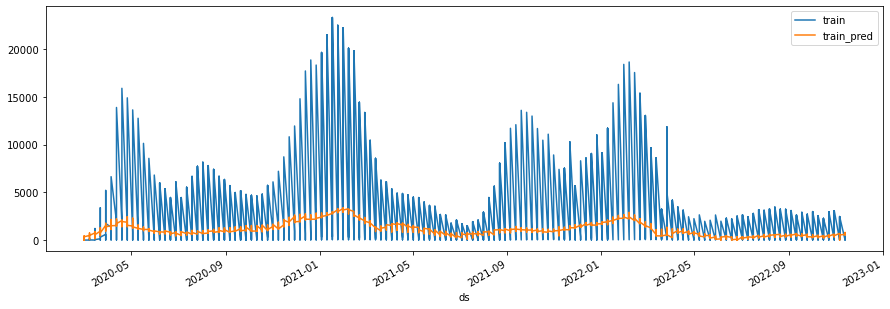

In [105]:
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([multivar_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])


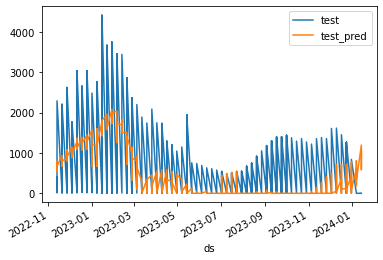

In [106]:
test_pred=model_multivariate.predict(multivar_test.reset_index()).set_index('ds')
test_pred['yhat'] = np.maximum(test_pred['yhat'], 0) # clamp negtaive values
pd.concat([multivar_test['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [107]:
mae = mean_absolute_error(multivar_test['y'],test_pred['yhat'])
r2 = r2_score(multivar_test['y'],test_pred['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(multivar_test['y'],test_pred['yhat'], y_train = multivar_train['y'])
new_row = {'country': 'All', 'model': 'Baseline Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Multivariate Prophet (Event + Holiday)

In [108]:
from prophet.make_holidays import make_holidays_df

year_list = [2020, 2021, 2022, 2023, 2024]
holidays_be = make_holidays_df(year_list=year_list, country='BE')
holidays_cl = make_holidays_df(year_list=year_list, country='CL')
holidays_ie = make_holidays_df(year_list=year_list, country='IE')
holidays_il = make_holidays_df(year_list=year_list, country='IL')
holidays_it = make_holidays_df(year_list=year_list, country='IT')
holidays_us = make_holidays_df(year_list=year_list, country='US')
holidays_cz = make_holidays_df(year_list=year_list, country='CZ')
holidays_ee = make_holidays_df(year_list=year_list, country='EE')
holidays_fr = make_holidays_df(year_list=year_list, country='FR')
holidays_my = make_holidays_df(year_list=year_list, country='MY')

all_holidays = pd.concat([holidays_be, holidays_cl, holidays_ie, holidays_il, holidays_it,
                          holidays_us, holidays_cz, holidays_ee, holidays_fr, holidays_my])


In [109]:
model_holiday = Prophet(holidays=all_holidays)
for col in multivar_train.columns:
    if col not in ['ds', 'y']:
        model_holiday.add_regressor(col)


model_holiday.fit(multivar_train.reset_index())

10:38:02 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
train_pred=model_holiday.predict(multivar_train.reset_index()).set_index('ds')

In [111]:
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,Armistice Day_lower,...,lag1_year,lag1_year_lower,lag1_year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-03-01,454.831107,-3520.855393,3558.420269,454.831107,454.831107,0.0,0.0,0.0,0.0,0.0,...,26471.727429,26471.727429,26471.727429,130.776998,130.776998,130.776998,0.0,0.0,0.0,3.064862
2020-03-01,454.831107,-3613.008154,3860.528304,454.831107,454.831107,0.0,0.0,0.0,0.0,0.0,...,-57.755812,-57.755812,-57.755812,130.776998,130.776998,130.776998,0.0,0.0,0.0,38.082802
2020-03-01,454.831107,-3507.830922,3673.094565,454.831107,454.831107,0.0,0.0,0.0,0.0,0.0,...,-57.755812,-57.755812,-57.755812,130.776998,130.776998,130.776998,0.0,0.0,0.0,94.042693
2020-03-01,454.831107,-3259.607845,3645.679488,454.831107,454.831107,0.0,0.0,0.0,0.0,0.0,...,26471.727429,26471.727429,26471.727429,130.776998,130.776998,130.776998,0.0,0.0,0.0,3.064862
2020-03-01,454.831107,-3133.670843,3777.355928,454.831107,454.831107,0.0,0.0,0.0,0.0,0.0,...,-57.755812,-57.755812,-57.755812,130.776998,130.776998,130.776998,0.0,0.0,0.0,416.653710


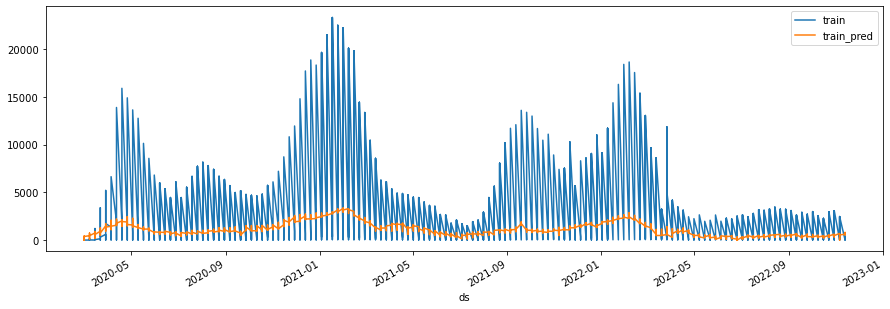

In [112]:
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([multivar_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])


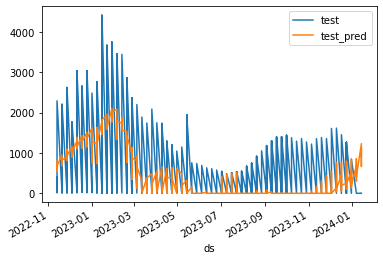

In [113]:
test_pred=model_holiday.predict(multivar_test.reset_index()).set_index('ds')
test_pred['yhat'] = np.maximum(test_pred['yhat'], 0) # clamp negtaive values
pd.concat([multivar_test['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [114]:
mae = mean_absolute_error(multivar_test['y'],test_pred['yhat'])
r2 = r2_score(multivar_test['y'],test_pred['yhat'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(multivar_test['y'],test_pred['yhat'], y_train = multivar_train['y'])
new_row = {'country': 'All', 'model': 'Holiday Prophet', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Metrics

In [115]:
metrics

,country,model,mae,mase,rsq
0,Belgium,Baseline Prophet,104.551047,0.3866,-40.896247
1,Belgium,Tuned Prophet,293.71163,1.086061,-182.132405
2,Chile,Baseline Prophet,470.160928,0.938079,-100.454527
3,Chile,Tuned Prophet,143.451409,0.286219,-27.807654
4,Ireland,Baseline Prophet,31.065978,0.471087,-14.281809
5,Ireland,Tuned Prophet,88.764344,1.34603,-50.589694
6,Israel,Baseline Prophet,42.473119,0.389076,-40.152801
7,Israel,Tuned Prophet,23.936533,0.219271,-12.084582
8,Italy,Baseline Prophet,787.720406,0.608484,-24.659705
9,Italy,Tuned Prophet,2483.88076,1.918703,-159.677668


In [116]:
metrics.sort_values('mase')

,country,model,mae,mase,rsq
18,Malaysia,Baseline Prophet,13.081967,0.037184,-0.524842
19,Malaysia,Tuned Prophet,45.447034,0.12918,-17.517124
7,Israel,Tuned Prophet,23.936533,0.219271,-12.084582
20,All,Baseline Prophet,453.318042,0.230344,-0.685816
21,All,Holiday Prophet,470.548885,0.2391,-0.741921
3,Chile,Tuned Prophet,143.451409,0.286219,-27.807654
11,US,Tuned Prophet,1915.055977,0.307233,-7.721244
15,Estonia,Tuned Prophet,7.94926,0.370946,-3.511519
0,Belgium,Baseline Prophet,104.551047,0.3866,-40.896247
6,Israel,Baseline Prophet,42.473119,0.389076,-40.152801


In [117]:
univar_df= metrics[metrics['country'] != 'All']
univar_df.sort_values('mase')

,country,model,mae,mase,rsq
18,Malaysia,Baseline Prophet,13.081967,0.037184,-0.524842
19,Malaysia,Tuned Prophet,45.447034,0.12918,-17.517124
7,Israel,Tuned Prophet,23.936533,0.219271,-12.084582
3,Chile,Tuned Prophet,143.451409,0.286219,-27.807654
11,US,Tuned Prophet,1915.055977,0.307233,-7.721244
15,Estonia,Tuned Prophet,7.94926,0.370946,-3.511519
0,Belgium,Baseline Prophet,104.551047,0.3866,-40.896247
6,Israel,Baseline Prophet,42.473119,0.389076,-40.152801
4,Ireland,Baseline Prophet,31.065978,0.471087,-14.281809
16,France,Baseline Prophet,606.738841,0.530326,-13.879152


In [118]:
multivar_df= metrics[metrics['country'] == 'All']
multivar_df.sort_values('mase')

,country,model,mae,mase,rsq
20,All,Baseline Prophet,453.318042,0.230344,-0.685816
21,All,Holiday Prophet,470.548885,0.2391,-0.741921
